In [ ]:
import numpy as np
import pandas as pd
from numpy import dot
from numpy.linalg import norm 
from numpy import array
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Replace Name with Title and Cabin with Area of the Ship

In [ ]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']

def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    return np.nan

In [ ]:
train['Name'] = train['Name'].apply(lambda x: substrings_in_string(x, title_list))
test['Name'] = test['Name'].apply(lambda x: substrings_in_string(x, title_list))

In [ ]:
train['Cabin'] = train['Cabin'].fillna('Unknown')
train['Cabin'] = train['Cabin'].apply(lambda x: substrings_in_string(x, cabin_list))

test['Cabin'] = test['Cabin'].fillna('Unknown')
test['Cabin'] = test['Cabin'].apply(lambda x: substrings_in_string(x, cabin_list))

Drop the Ticket column. Cannot see any useable information from this

In [ ]:
train = train.drop(columns=['Ticket'])
test = test.drop(columns=['Ticket'])

There are two empty Embarked rows in the training set. Just fill these with the most common Embarkment

In [ ]:
print('Number of passengers embarked from C = ', (train['Embarked'] == 'C').sum())
print('Number of passengers embarked from Q = ', (train['Embarked'] == 'Q').sum())
print('Number of passengers embarked from S = ', (train['Embarked'] == 'S').sum())

Number of passengers embarked from C =  168
Number of passengers embarked from Q =  77
Number of passengers embarked from S =  644


It looks like they most likely embarked from Southampton S

In [ ]:
train['Embarked'] = train['Embarked'].fillna('S')

There is one missing Fare row in the test set. Just fill this with the average Fare

In [ ]:
avg_fare = np.mean(test['Fare'])
test['Fare'] = test['Fare'].fillna(avg_fare)

One-hot-encode categorical variables

In [ ]:
train = pd.get_dummies(train, columns=['Pclass', 'Name', 'Sex', 'Cabin', 'Embarked'])
test = pd.get_dummies(test, columns=['Pclass', 'Name', 'Sex', 'Cabin', 'Embarked'])

Normalize continuous features

In [ ]:
max_sibsp = max(train['SibSp'])
train['SibSp'] = train['SibSp'].apply(lambda x: x / max_sibsp)
max_sibsp = max(test['SibSp'])
test['SibSp'] = test['SibSp'].apply(lambda x: x / max_sibsp)

max_parch = max(train['Parch'])
train['Parch'] = train['Parch'].apply(lambda x: x / max_parch)
max_parch = max(test['Parch'])
test['Parch'] = test['Parch'].apply(lambda x: x / max_parch)

max_fare = max(train['Fare'])
min_fare = min(train['Fare'])
train['Fare'] = train['Fare'].apply(lambda x: (x - min_fare) / (max_fare - min_fare))
max_fare = max(test['Fare'])
min_fare = min(test['Fare'])
test['Fare'] = test['Fare'].apply(lambda x: (x - min_fare) / (max_fare - min_fare))

To deal with the null Age cells, we perform a k-NN algorithm to fill in the missing values

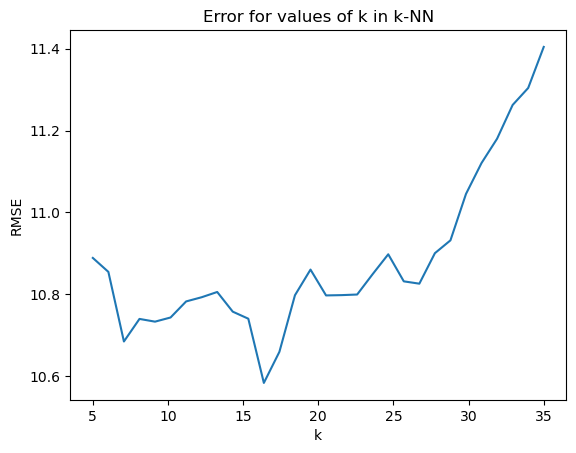

In [ ]:
# Determine best value of k
train_dropna = train.dropna()
X_train, X_test, y_train, y_test = train_test_split(train_dropna.drop(columns=['PassengerId', 'Age']), 
                                                    train_dropna['Age'], test_size=0.2, random_state=42)

x = np.linspace(5, 35, 30)
y = np.zeros(30)
for k in range(5, 35):
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    y[k-5] = np.sqrt(mean_squared_error(y_pred, y_test))

plt.plot(x, y)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('Error for values of k in k-NN')
plt.show()

It looks like the best value of k is 16. Let us use 16-NN to predict the missing Age values

In [ ]:
neigh = KNeighborsRegressor(n_neighbors=16)
neigh.fit(train_dropna.drop(columns=['PassengerId', 'Age']), train_dropna['Age'])
age_pred = neigh.predict(train[train['Age'].isnull()].drop(columns=['PassengerId', 'Age']))

In [ ]:
null_indices = train[train['Age'].isnull()].index
train.loc[null_indices, 'Age'] = age_pred

Let us do the same thing with the missing Age values in the test set

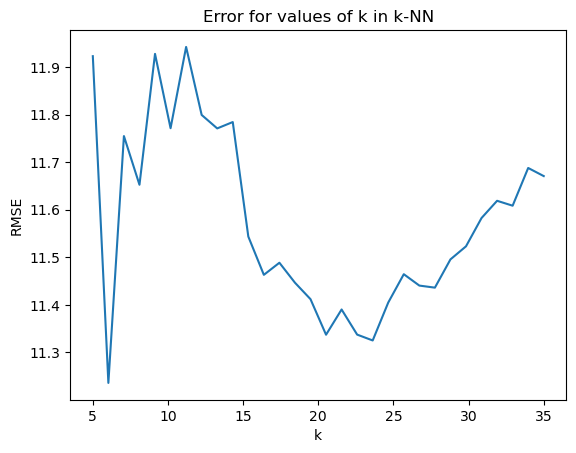

In [ ]:
# Determine best value of k
test_dropna = test.dropna()
X_train, X_test, y_train, y_test = train_test_split(test_dropna.drop(columns=['PassengerId', 'Age']), 
                                                    test_dropna['Age'], test_size=0.2, random_state=42)

x = np.linspace(5, 35, 30)
y = np.zeros(30)
for k in range(5, 35):
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    y[k-5] = np.sqrt(mean_squared_error(y_pred, y_test))

plt.plot(x, y)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('Error for values of k in k-NN')
plt.show()

It looks like a good value for k is 24

In [ ]:
neigh = KNeighborsRegressor(n_neighbors=24)
neigh.fit(test_dropna.drop(columns=['PassengerId', 'Age']), test_dropna['Age'])
age_pred = neigh.predict(test[test['Age'].isnull()].drop(columns=['PassengerId', 'Age']))

In [ ]:
null_indices = test[test['Age'].isnull()].index
test.loc[null_indices, 'Age'] = age_pred

Normalize ages

In [ ]:
max_age = max(train['Age'])
min_age = min(train['Age'])
train['Age'] = train['Age'].apply(lambda x: (x - min_age) / (max_age - min_age))

In [ ]:
max_age = max(test['Age'])
min_age = min(test['Age'])
test['Age'] = test['Age'].apply(lambda x: (x - min_age) / (max_age - min_age))

Run several classification algorithms on the training data to determine which one is optimal

In [ ]:
ml_algorithms = {'Logistic Regression':LogisticRegression(random_state=0, max_iter=1000), 
                 'Random Forest':RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1),
                 'SVM':SVC(gamma='auto')}

for name, ml_alg in ml_algorithms.items():

    cv_results = cross_validate(ml_alg, train.drop(columns=['PassengerId', 'Survived']), train['Survived'], scoring='f1')
    print('Avg F1 score for ', name, ' = ', np.mean(cv_results['test_score']))

Avg F1 score for  Logistic Regression  =  0.771472440728225
Avg F1 score for  Random Forest  =  0.756005954851802
Avg F1 score for  SVM  =  0.7293984642687577


It looks like Logistic Regression is the way to go! Let us run this algorithm on the test data

In [ ]:
log_reg = LogisticRegression(random_state=0, max_iter=1000)

log_reg.fit(train.drop(columns=['PassengerId', 'Survived']), train['Survived'])
y_pred = log_reg.predict(test.drop(columns=['PassengerId']))

submission = pd.DataFrame(test['PassengerId'], y_pred)